In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from scipy.stats import wasserstein_distance
from collections import Counter
from datetime import date, timedelta
from itertools import groupby

In [200]:
custom_palette = ["#7CBFAF", "#5B7E37"]

sns.set_theme(style="whitegrid", palette=custom_palette)
plt.rcParams['axes.facecolor'] = '#FCFAFD'
plt.rcParams['figure.facecolor'] = '#FCFAFD'

In [201]:
def minutes_to_hhmm(x, _):
    h = int(x) // 60
    m = int(x) % 60
    return f"{h:02}:{m:02}"

In [202]:
with open("not_me_first_message.txt") as f:
    not_me_times = [line.strip() for line in f if line.strip()]

with open("me_first_message.txt") as f:
    me_times = [line.strip() for line in f if line.strip()]

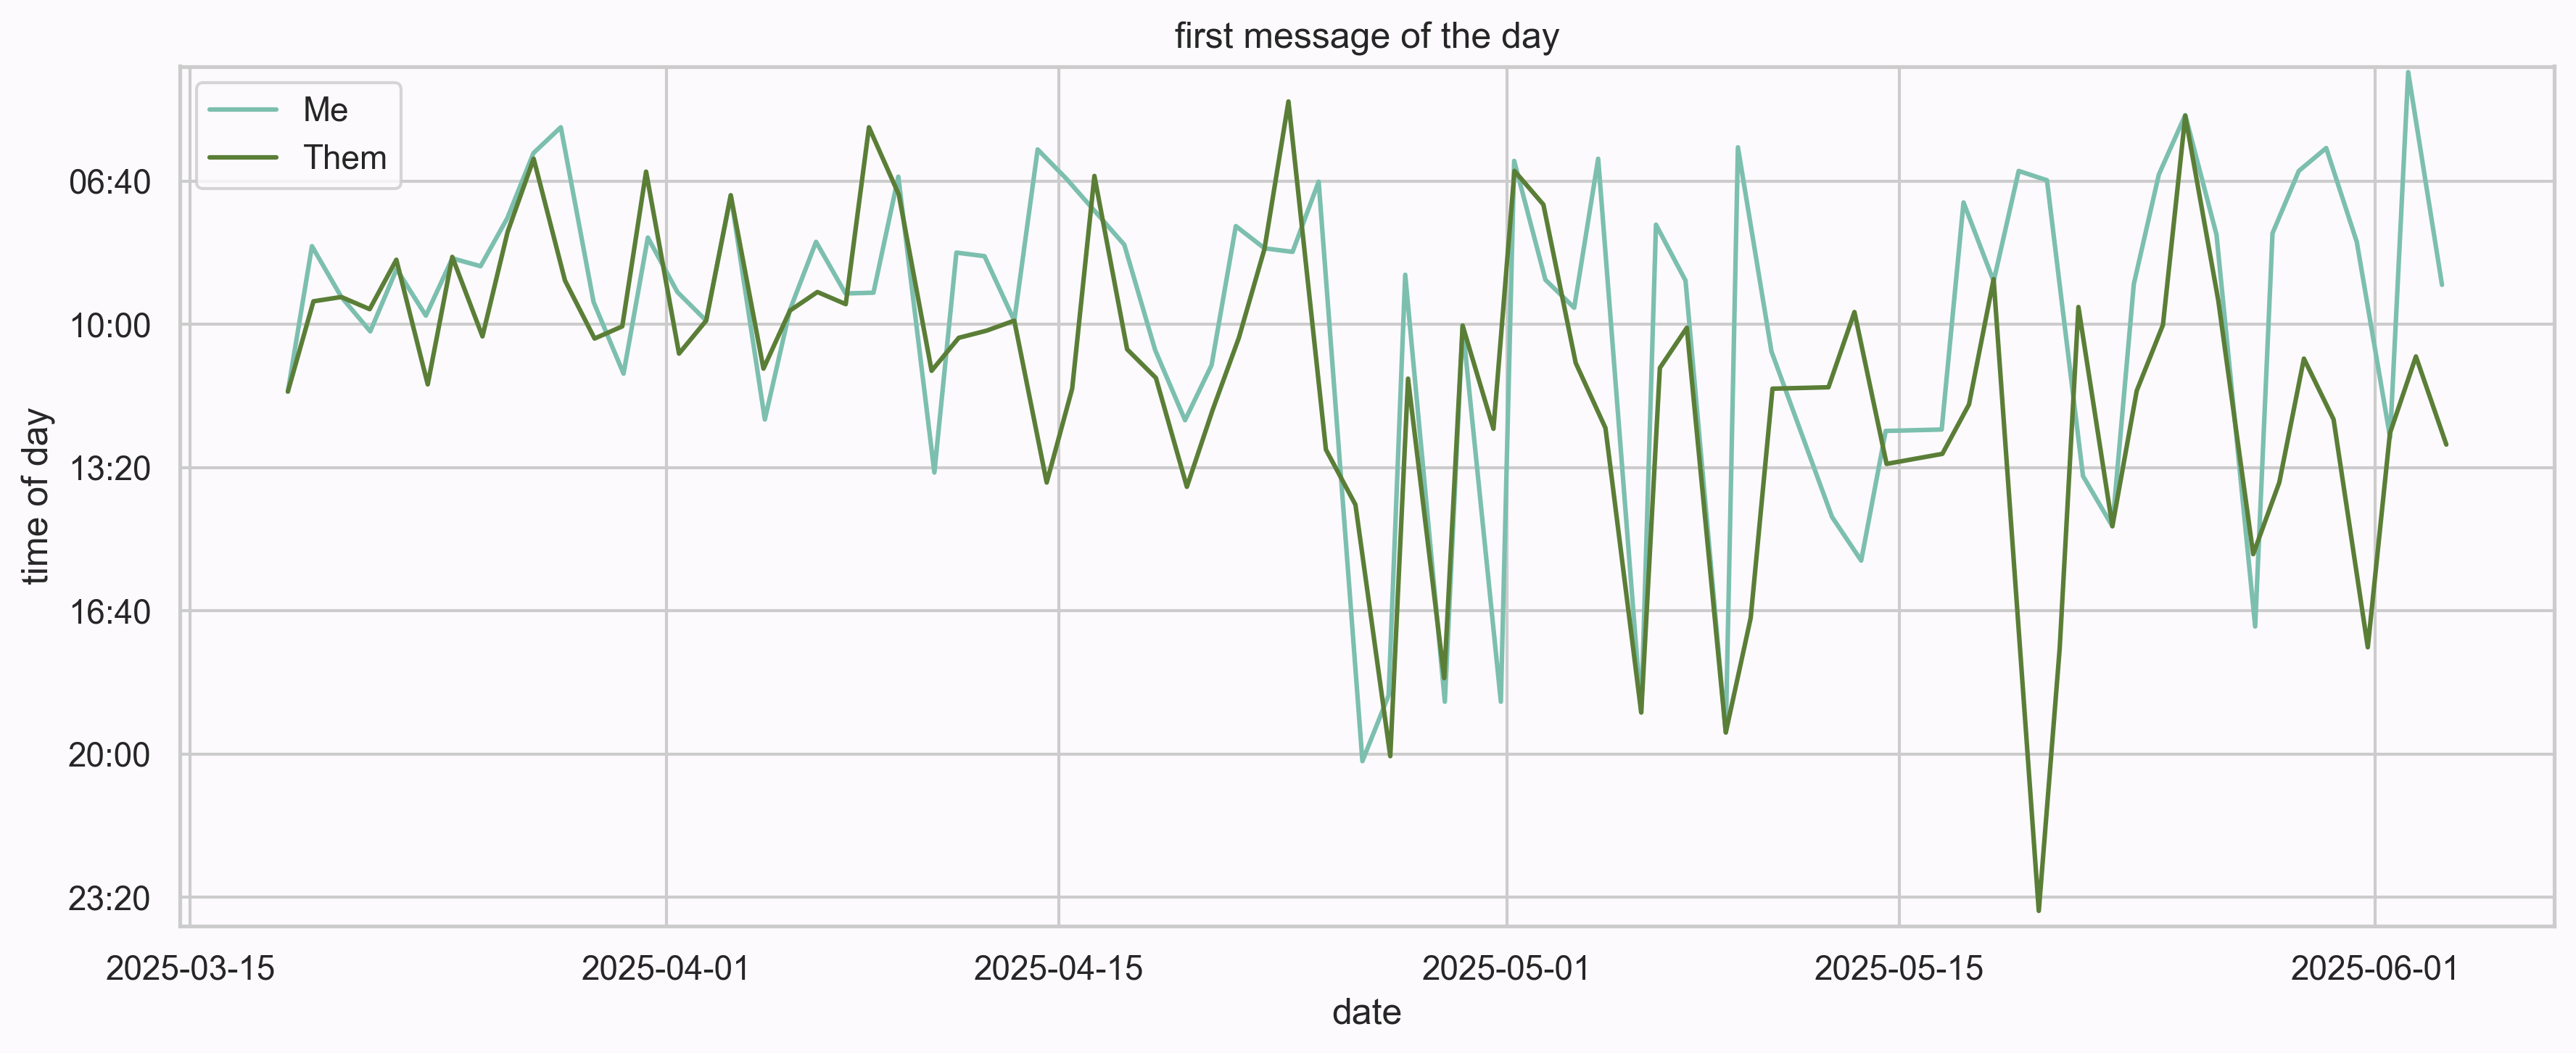

In [203]:
def first_contact_comparison(me_times, not_me_times):
    me_df = pd.DataFrame({'datetime': pd.to_datetime(me_times)})
    me_df['time_of_day_minutes'] = me_df['datetime'].dt.hour * 60 + me_df['datetime'].dt.minute
    me_df = me_df.sort_values('datetime')
    not_me_df = pd.DataFrame({'datetime': pd.to_datetime(not_me_times)})
    not_me_df['time_of_day_minutes'] = not_me_df['datetime'].dt.hour * 60 + not_me_df['datetime'].dt.minute
    not_me_df = not_me_df.sort_values('datetime')
    plt.figure(figsize=(12, 5), dpi=300)
    plt.plot(me_df['datetime'], me_df['time_of_day_minutes'], label="Me", linewidth=1.5)
    plt.plot(not_me_df['datetime'], not_me_df['time_of_day_minutes'], label="Them", linewidth=1.5)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(minutes_to_hhmm))
    plt.ylim(1440, 240)
    plt.title("first message of the day")
    plt.xlabel("date")
    plt.ylabel("time of day")
    plt.legend()
    plt.tight_layout()
    plt.show()
first_contact_comparison(me_times, not_me_times)

In [204]:
def find_shift_point(times):
    df = pd.DataFrame({'datetime': pd.to_datetime(times)})
    df['minutes'] = df['datetime'].dt.hour * 60 + df['datetime'].dt.minute
    df = df.sort_values('datetime').reset_index(drop=True)
    scores = []
    for i in range(10, len(df)-10):  
        before = df.loc[:i-1, 'minutes']
        after = df.loc[i:, 'minutes']
        diff = np.median(after) - np.median(before)
        scores.append((df.loc[i, 'datetime'].date(), diff))
    return pd.DataFrame(scores, columns=["date", "median_diff"])

what is this 
- so we want to know if the Incident is reflected in our texting behavior, so we want to look for a point that Changed things...
- using median makes sense here -- it doesn't make sense to find the 'average' time that something happens by adding up time -- since time doesn't work like that! 
- if i take medicine either at morning or at night, this doesn't mean noon is meaningful 
- we split the 'first text' data using every day (except the first and last days) as a cutoff 
- then we calculate the difference in medians 
- basically a 'lite' version of bootstrapping 
- in bootstrapping, we'd repeatedly resample data from each split... -- because there's only 76 days, there's no point

In [205]:
me1 = find_shift_point(me_times)
them1 = find_shift_point(not_me_times)

In [206]:
def plot_shift_results(results_df):
    results_df = results_df.sort_values("date")
    x = pd.to_datetime(results_df["date"])
    y = results_df["median_diff"]
    plt.figure(figsize=(10, 5), dpi=300)
    plt.plot(x, y, linewidth=2)
    plt.axhline(0, linestyle='--', color='gray')
    plt.title("median first message time at different date cutoffs")
    plt.xlabel("Date")
    plt.ylabel("median difference (in minutes)")
    plt.tight_layout()
    plt.show()

def print_top_shifts(results_df, top_n=3):
    top = results_df.reindex(results_df['median_diff'].abs().sort_values(ascending=False).index).head(top_n)
    print(f"top {top_n} most significant change points (by absolute median shift):")
    print(top)

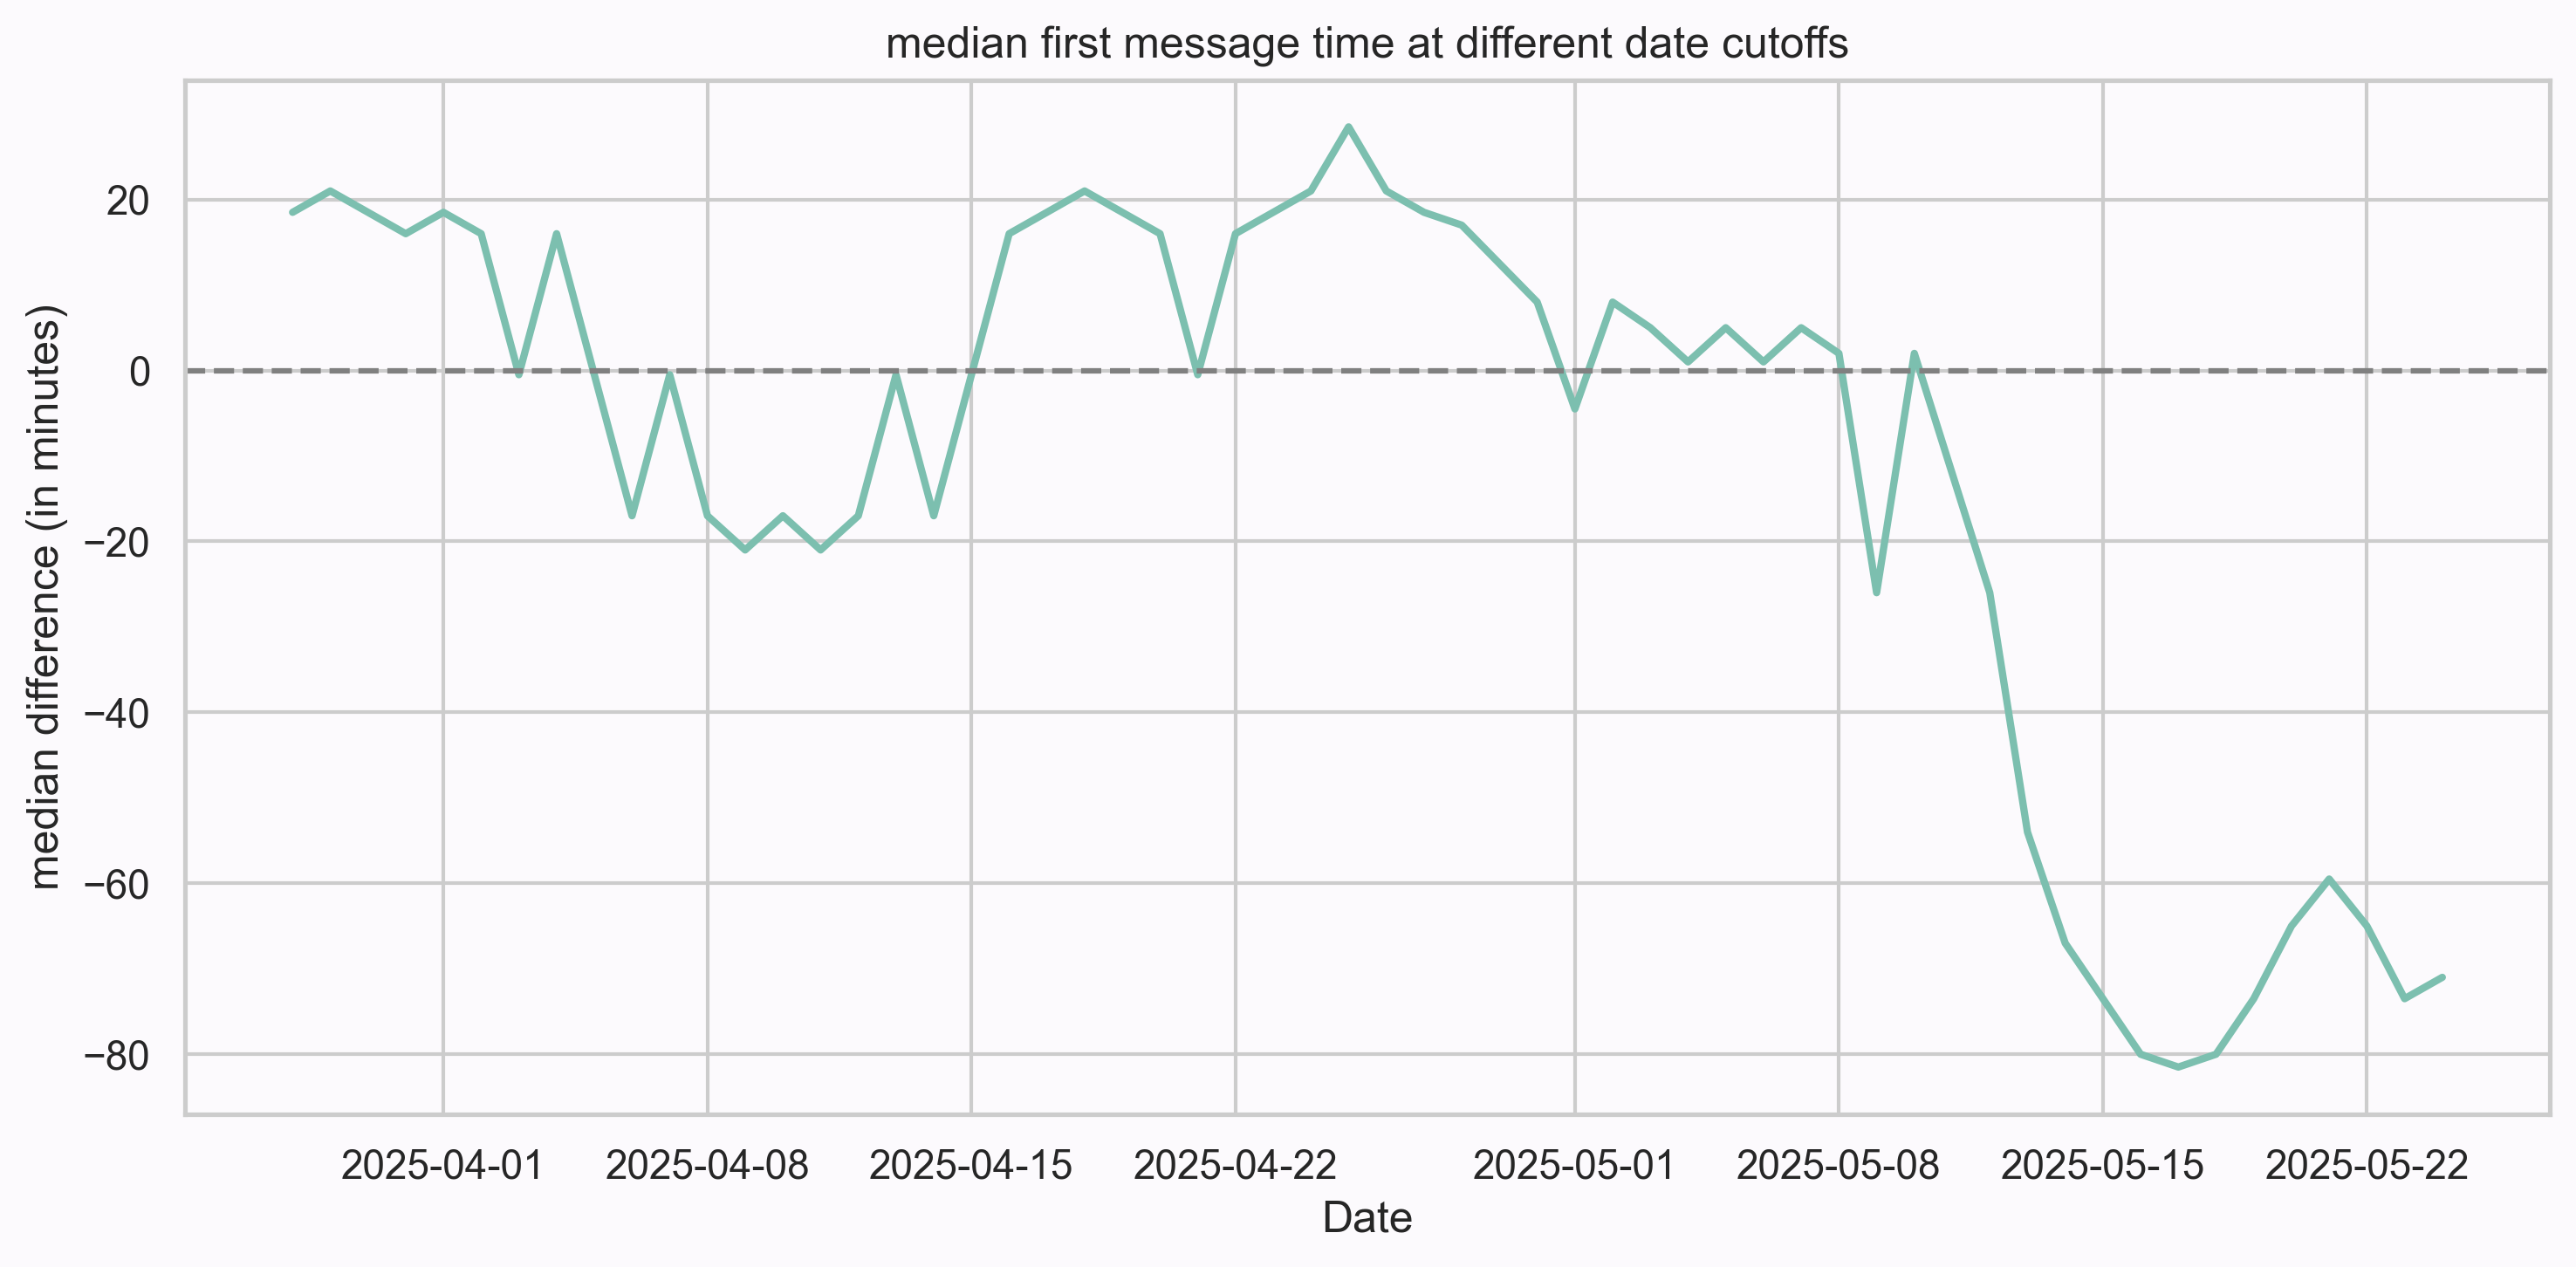

In [207]:
plot_shift_results(me1)

- so lower difference (like what i have) is that i started replying earlier in the day (my later distributions' medians were smaller)

In [208]:
print_top_shifts(me1)

top 3 most significant change points (by absolute median shift):
          date  median_diff
48  2025-05-17    -81.50000
49  2025-05-18    -80.00000
47  2025-05-16    -80.00000


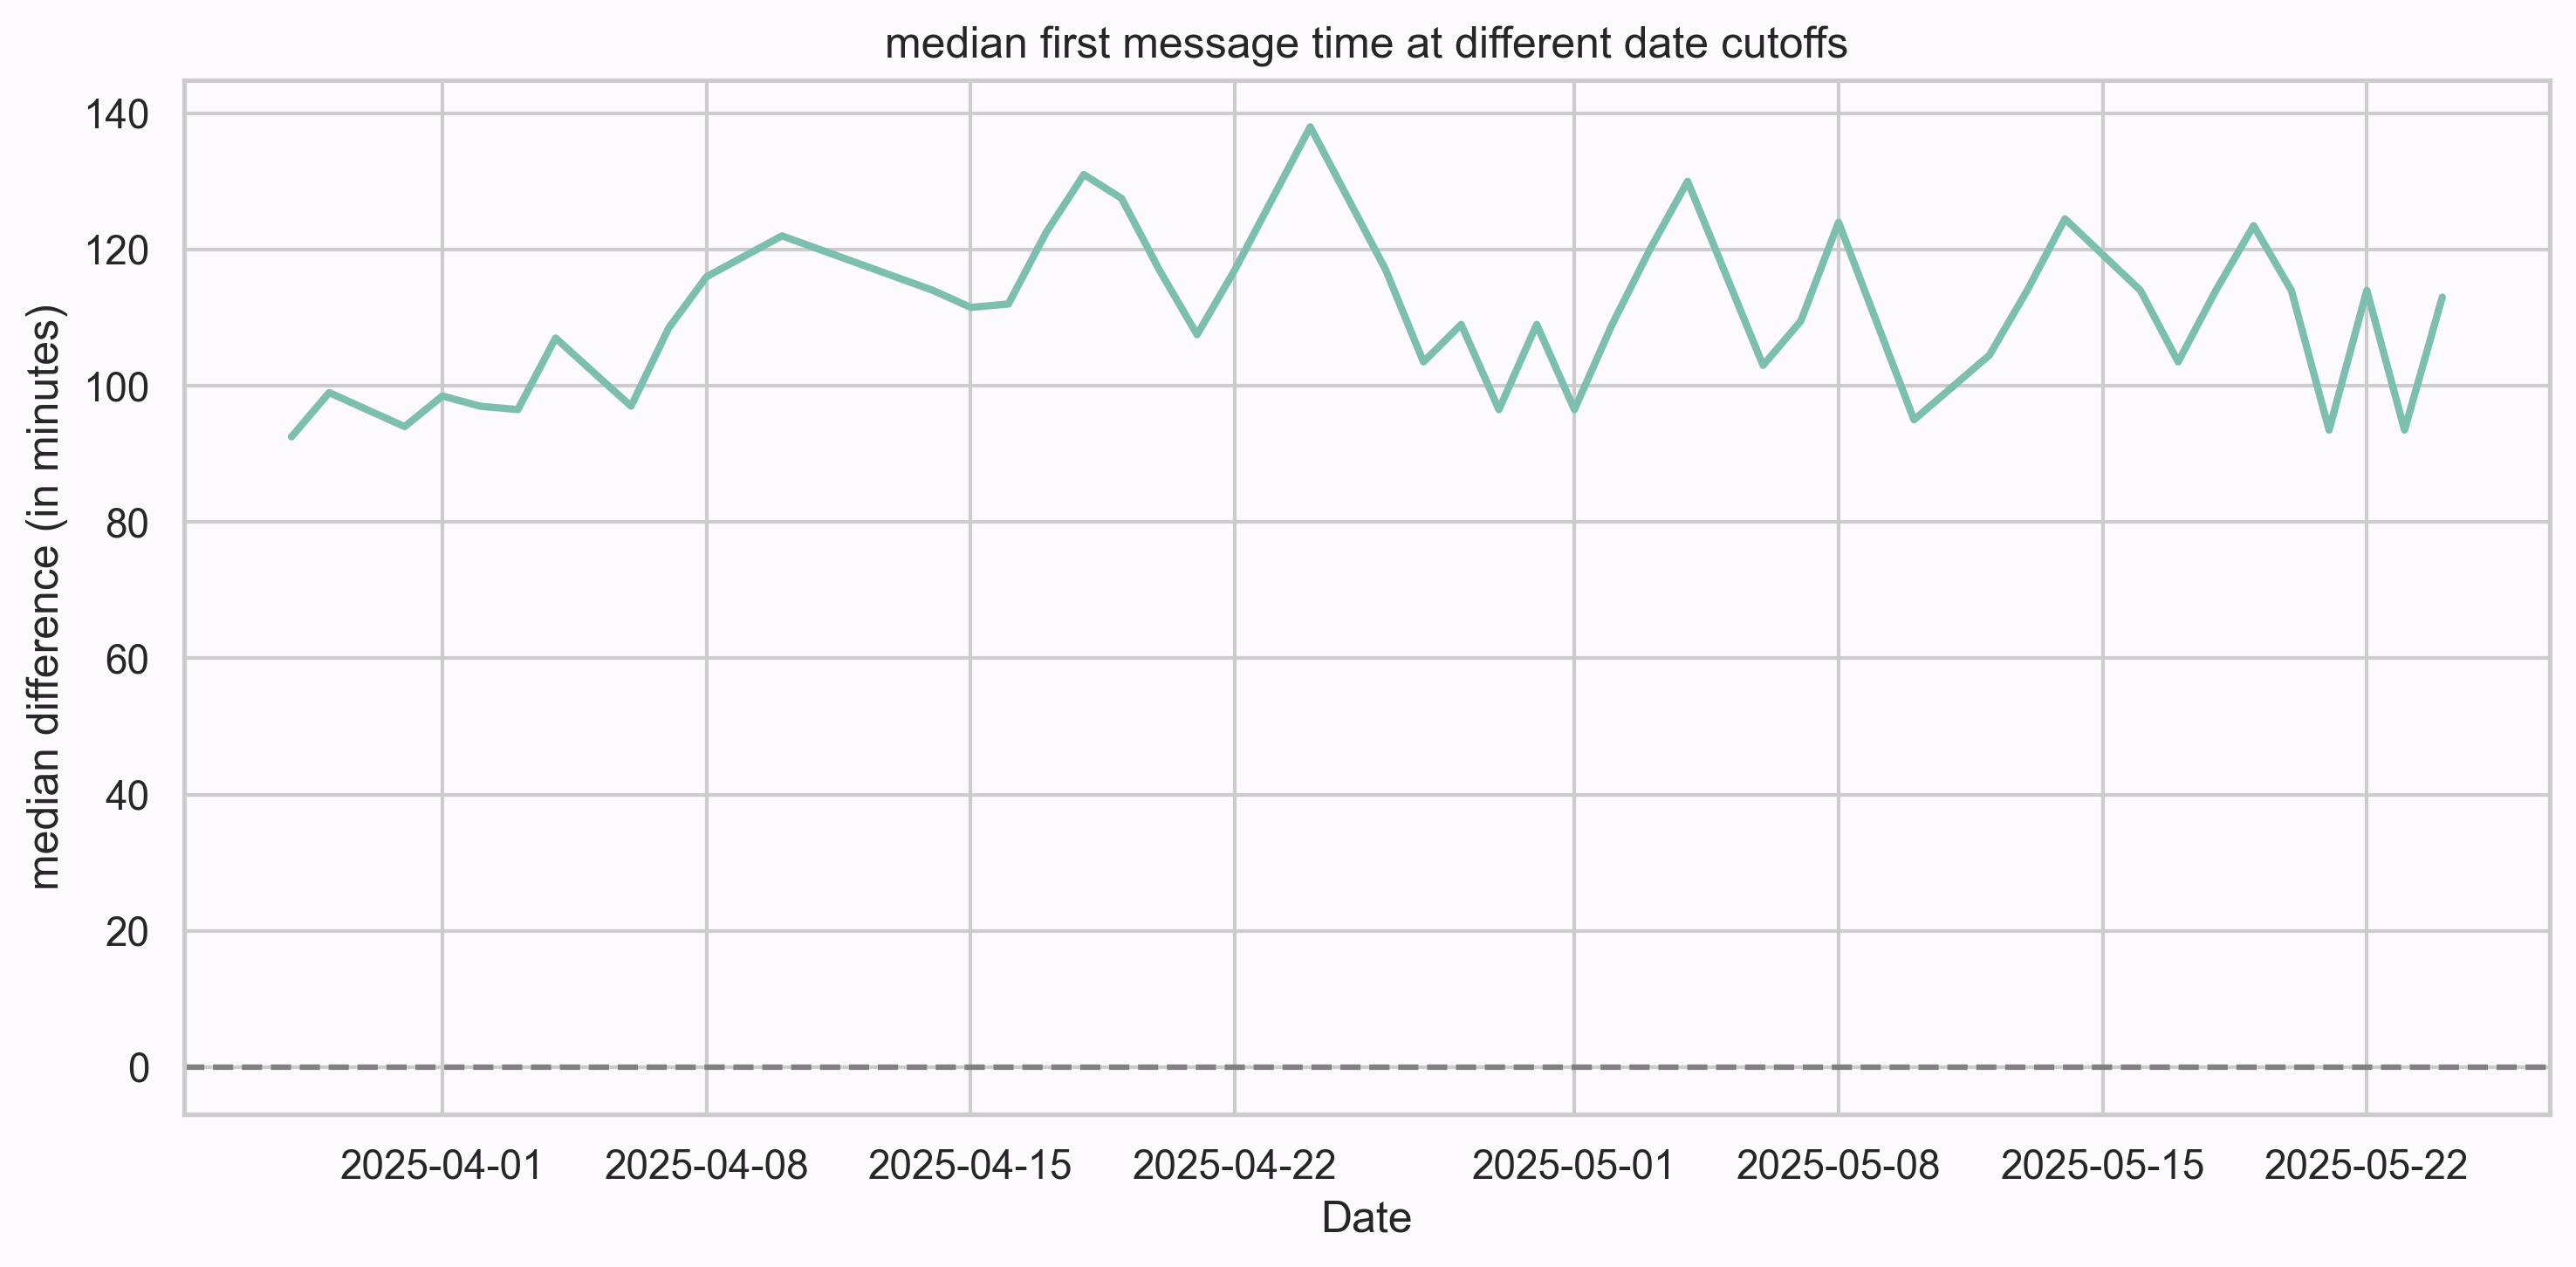

In [209]:
plot_shift_results(them1)

- they started replying later and later in the day (consistent downwards trend)

In [210]:
print_top_shifts(them1)

top 3 most significant change points (by absolute median shift):
          date  median_diff
27  2025-04-24    138.00000
21  2025-04-18    131.00000
37  2025-05-04    130.00000


2

In [211]:
coins = pd.read_csv("binomial_input.csv")
coins['date'] = pd.to_datetime(coins["date"], format="mixed").dt.tz_localize(None)
runs = [x for x in coins['author']]

In [212]:
len(coins)

15965

In [213]:
counts = Counter(runs)
print(f"i sent {counts['Me']} messages, they sent {counts['Them']} messages")


i sent 8183 messages, they sent 7782 messages


- we're assuming that the probability of each run is independent and identically distributed random variables (put a pin in that)
- so we need to find the 'base' probability of a message from either one of us showing up, simply: 

In [214]:
print (f"my empirical p -- {counts['Me']/len(coins)}")
print (f"their empirical p -- {counts['Them']/len(coins)}")

my empirical p -- 0.512558722204823
their empirical p -- 0.48744127779517693


In [215]:
the_runs = [(key, sum(1 for _ in group)) for key, group in groupby(runs)]

In [216]:
me_run_lengths = [length for author, length in the_runs if author == 'Me']
them_run_lengths = [length for author, length in the_runs if author == 'Them']


In [217]:
def plot_run_length_comparison(me_run_lengths, them_run_lengths, p_me = 0.5125, p_them= 0.4874 ):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=300, sharey=True)
    bar_colors = ['#7CBFAF', '#5B7E37']      
    line_color = '#A94E46'                
    for ax, run_lengths, p, label, bar_color in zip(
        axes,
        [me_run_lengths, them_run_lengths],
        [p_me, p_them],
        ['my', 'their'],
        bar_colors):
        counts = Counter(run_lengths)
        observed_lengths = np.array(sorted(counts.keys()))
        observed_freqs = np.array([counts[k] for k in observed_lengths])
        expected_probs = [(1 - p) * p**(k - 1) for k in observed_lengths]
        expected_counts = np.array(expected_probs) * sum(observed_freqs)
        ax.bar(observed_lengths, observed_freqs, width=0.4, label='Observed', align='center', color=bar_color, alpha=0.8)
        ax.plot(observed_lengths, expected_counts, 'o-', label='Expected (Geometric)', linewidth=2, color=line_color)
        ax.set_title(f'{label} run lengths')
        ax.set_xlabel('run length')
        ax.set_ylabel('frequency')
        ax.legend()
    plt.tight_layout()
    plt.show()

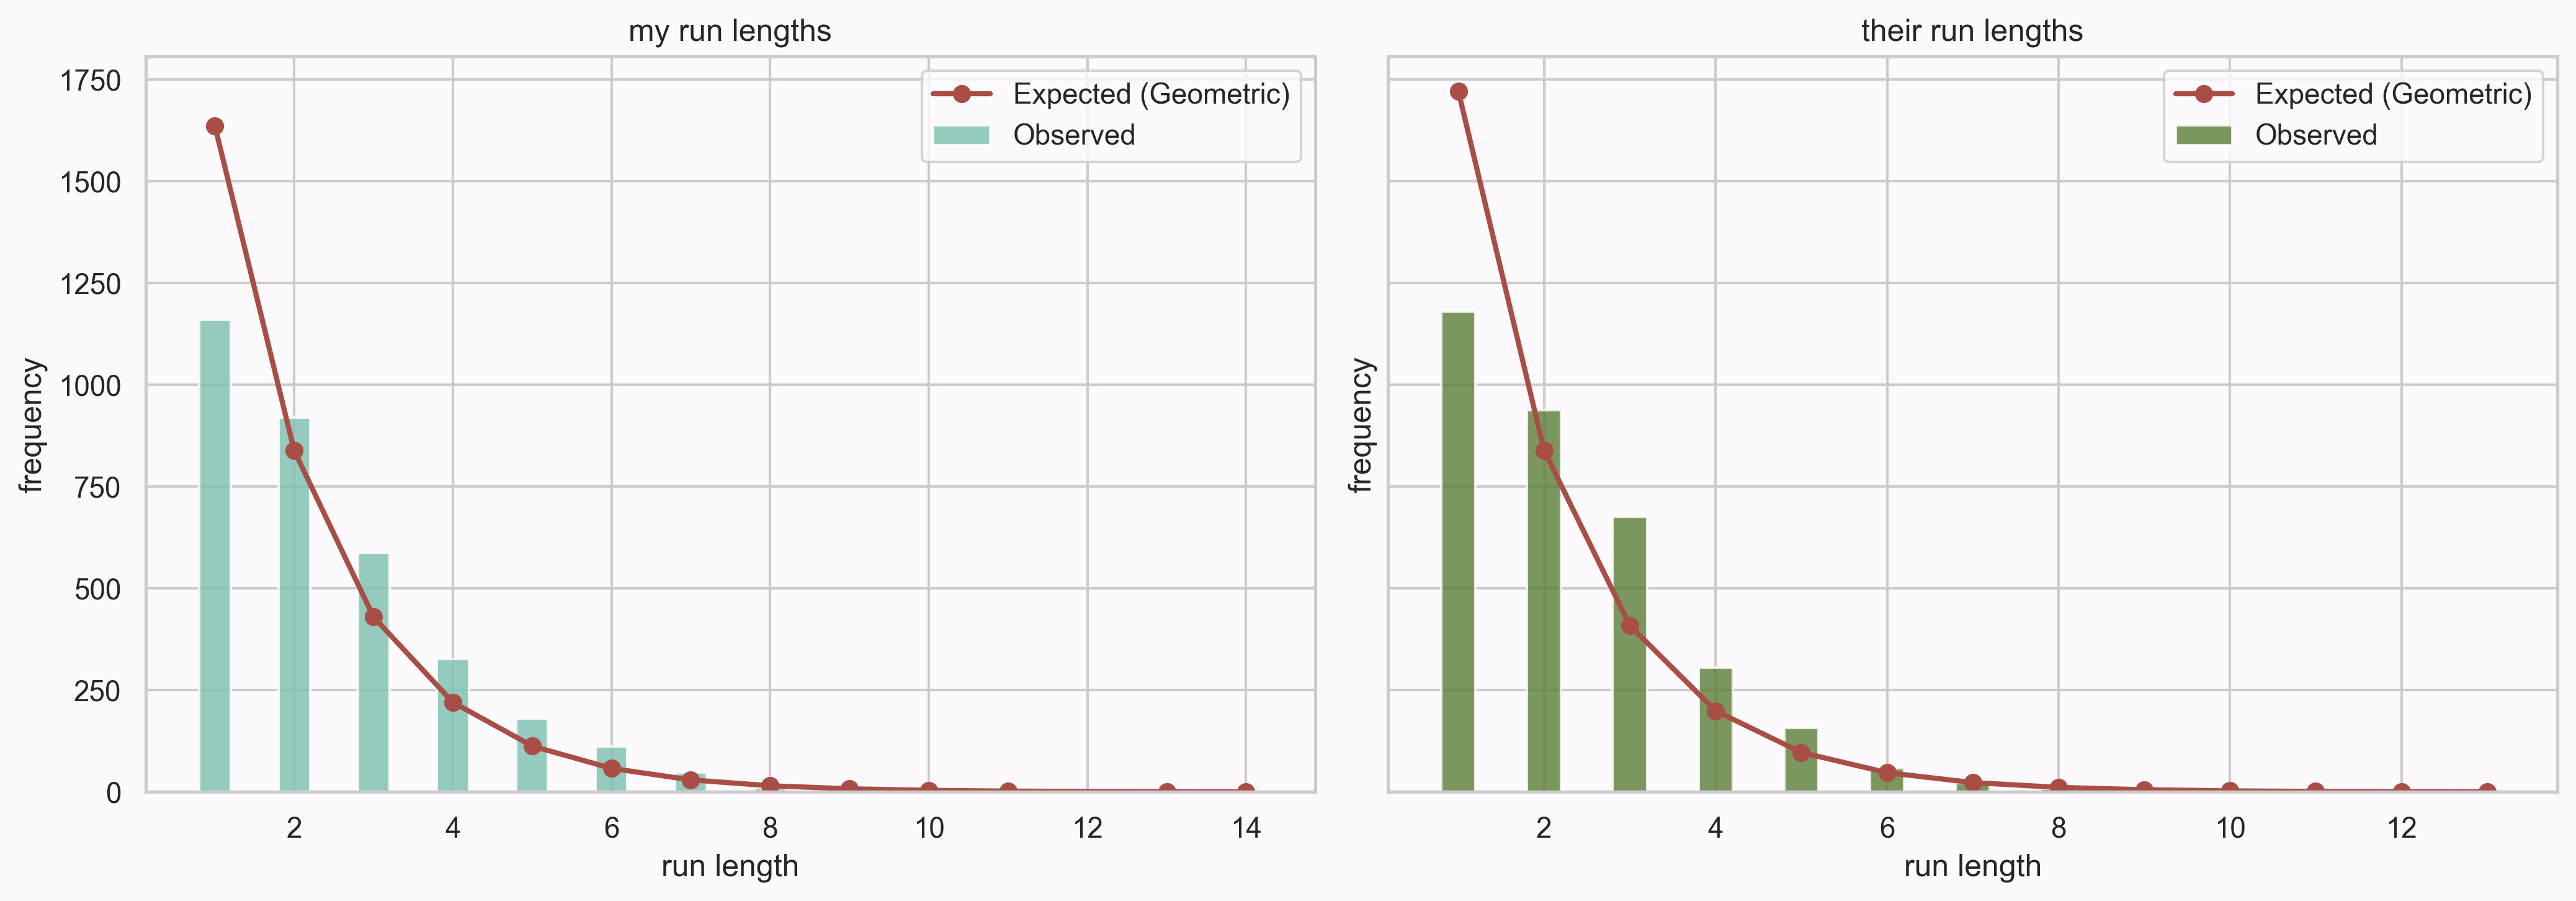

In [218]:
plot_run_length_comparison(me_run_lengths, them_run_lengths)

- obviously i was thinking of the coin flip problem from pset3, but what i want to know is a little different -- we're looking at the results of coin flips, and we want to figure out if someone just started making up the results at some point. 

In [219]:
pairs = [
    (the_runs[i][0], the_runs[i][1], the_runs[i+1][0], the_runs[i+1][1])
    for i in range(len(the_runs)-1)
    if the_runs[i][0] != the_runs[i+1][0]
]

local_ratios = []
for a1, l1, a2, l2 in pairs:
    if {a1, a2} == {'Me', 'Them'}:
        me_len = l1 if a1 == 'Me' else l2
        them_len = l1 if a1 == 'Them' else l2
        local_ratios.append(me_len / (me_len + them_len))  # my share of this exchange

run_indices = []
i = 0
for speaker, length in the_runs:
    run_indices.append((speaker, length, i))  # i = start index of run in coins
    i += length

    
local_dates = []
for i in range(len(run_indices) - 1):
    a1, _, idx1 = run_indices[i]
    a2, _, idx2 = run_indices[i + 1]
    if {a1, a2} == {'Me', 'Them'}:
        start_idx = min(idx1, idx2)
        local_dates.append(coins.iloc[start_idx]['date'])

In [220]:
def get_transition_matrix(author_sequence):
    transitions = list(zip(author_sequence[:-1], author_sequence[1:]))
    counts = Counter(transitions)
    total_from = Counter(a for a, _ in transitions)
    matrix = {}
    for (a1, a2), count in counts.items():
        matrix[(a1, a2)] = count / total_from[a1]
    return matrix

def log_likelihood(segment, trans_probs):
    ll = 0
    for a1, a2 in zip(segment[:-1], segment[1:]):
        prob = trans_probs.get((a1, a2), 1e-8)
        ll += np.log(prob)
    return ll

def scan_for_change_point(sequence):
    n = len(sequence)
    global_model = get_transition_matrix(sequence)
    global_ll = log_likelihood(sequence, global_model)
    best_k = None
    best_diff = -np.inf
    diffs = []
    for k in range(10, n - 10):
        seq1 = sequence[:k]
        seq2 = sequence[k:]
        model1 = get_transition_matrix(seq1)
        model2 = get_transition_matrix(seq2)
        ll1 = log_likelihood(seq1, model1)
        ll2 = log_likelihood(seq2, model2)
        piecewise_ll = ll1 + ll2
        diff = piecewise_ll - global_ll
        diffs.append(diff)
        if diff > best_diff:
            best_diff = diff
            best_k = k
    return best_k, best_diff, diffs

def plot_point_change(the_runs, coins, step=2000):
    author_sequence = [a for a, l in the_runs for _ in range(l)]
    best_idx, _, diffs = scan_for_change_point(author_sequence)

    max_idx = min(len(diffs), len(coins))
    label_indices = list(range(0, max_idx, step))
    date_labels = [
        pd.to_datetime(coins.iloc[i]['date']).strftime('%m-%d')
        for i in label_indices
    ]
    plt.figure(figsize=(10, 4), dpi=300)
    plt.plot(diffs)
    plt.axvline(best_idx, color='red', linestyle='--', label='best change point')
    plt.xticks(label_indices, date_labels, ha='right')
    plt.xlabel("day")
    plt.ylabel("log-likelihood improvement")
    plt.title("first order markov change point detecting")
    plt.legend()
    plt.tight_layout()
    plt.show()

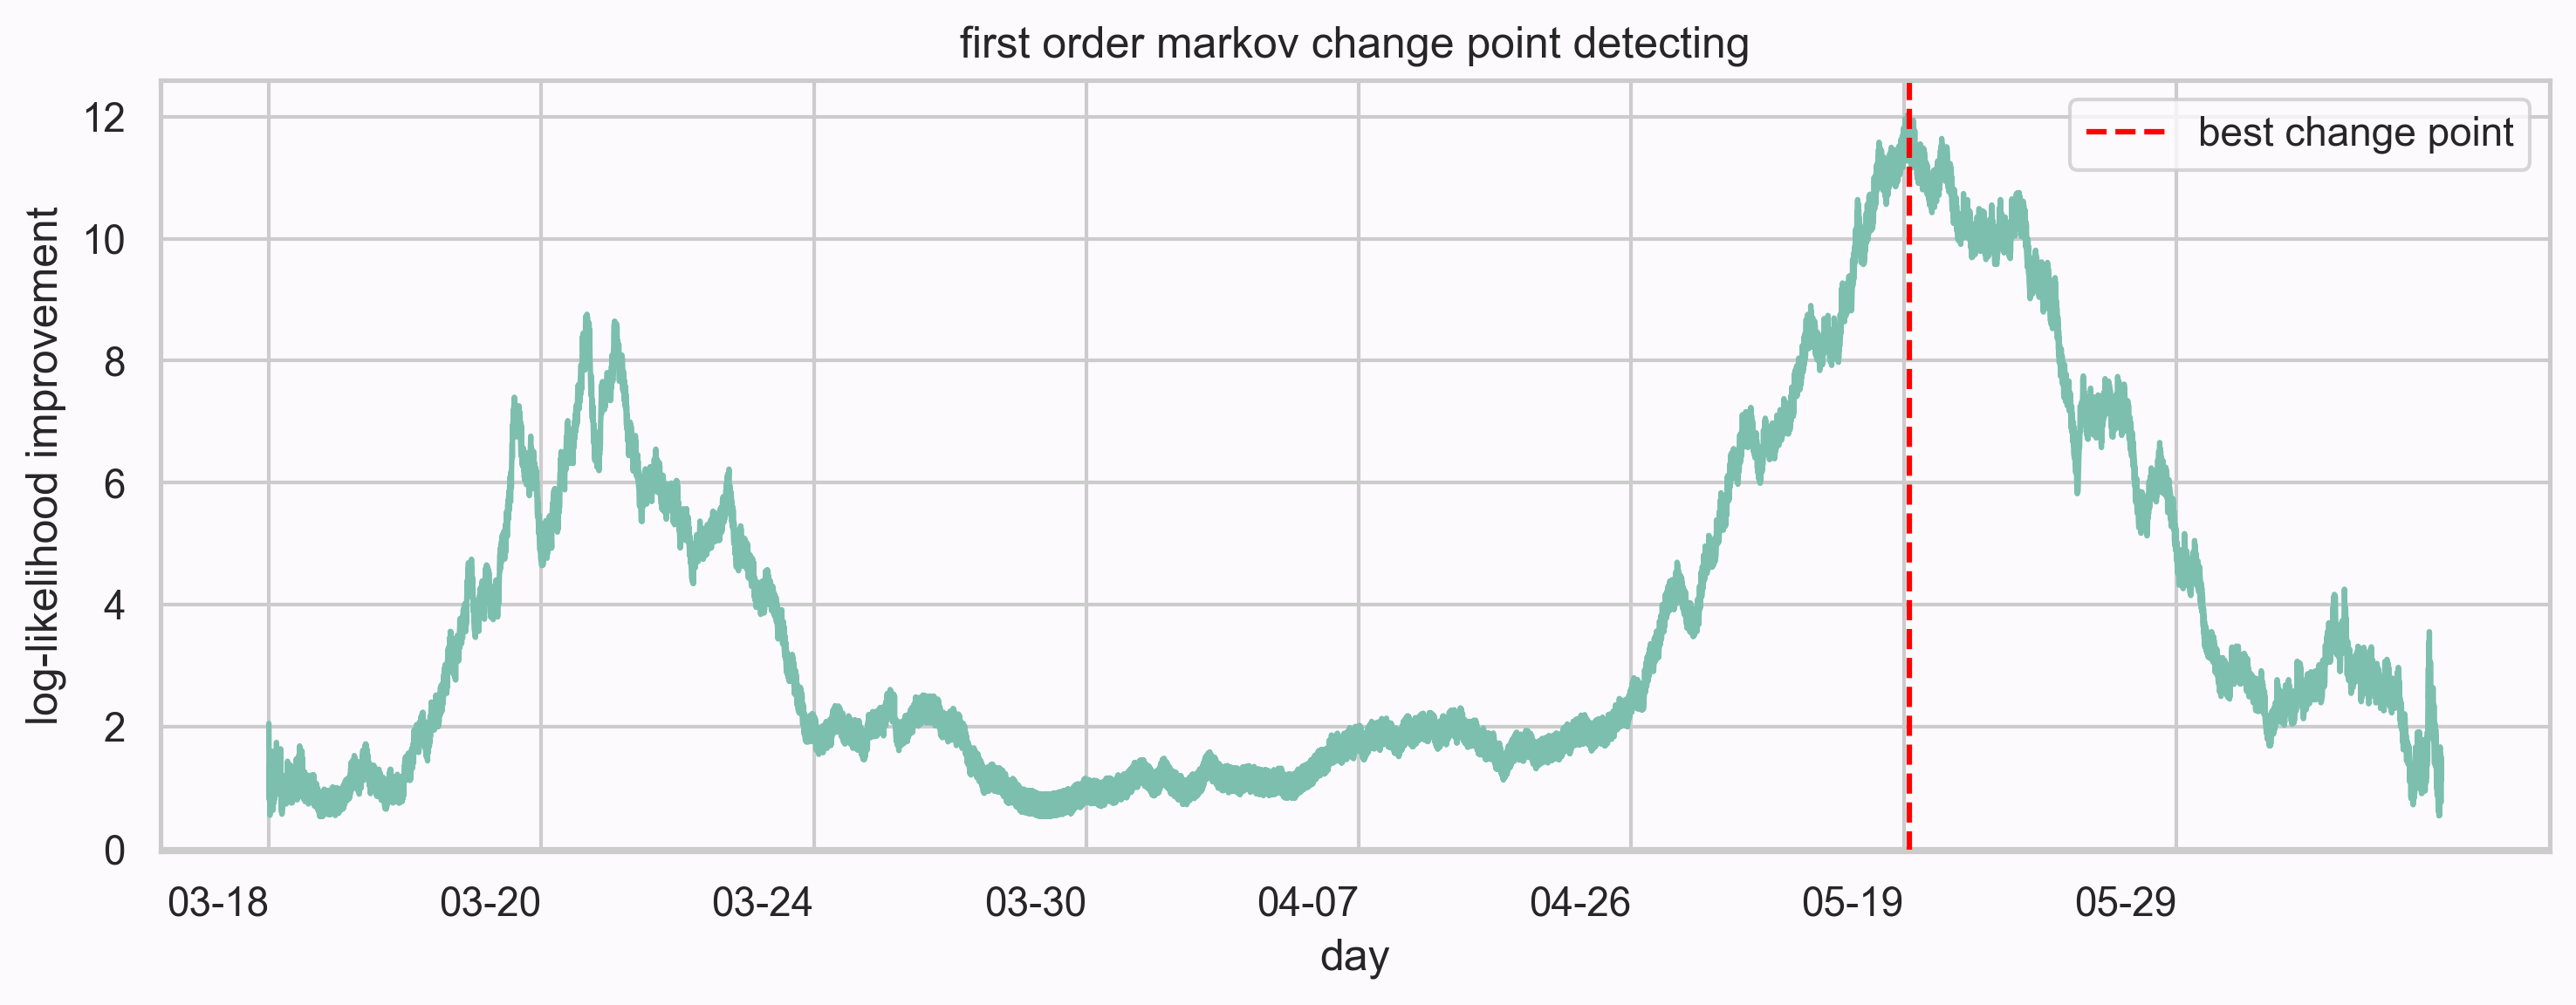

In [221]:
plot_point_change(the_runs, coins)

3
now we want to see how conversation length changed over time 

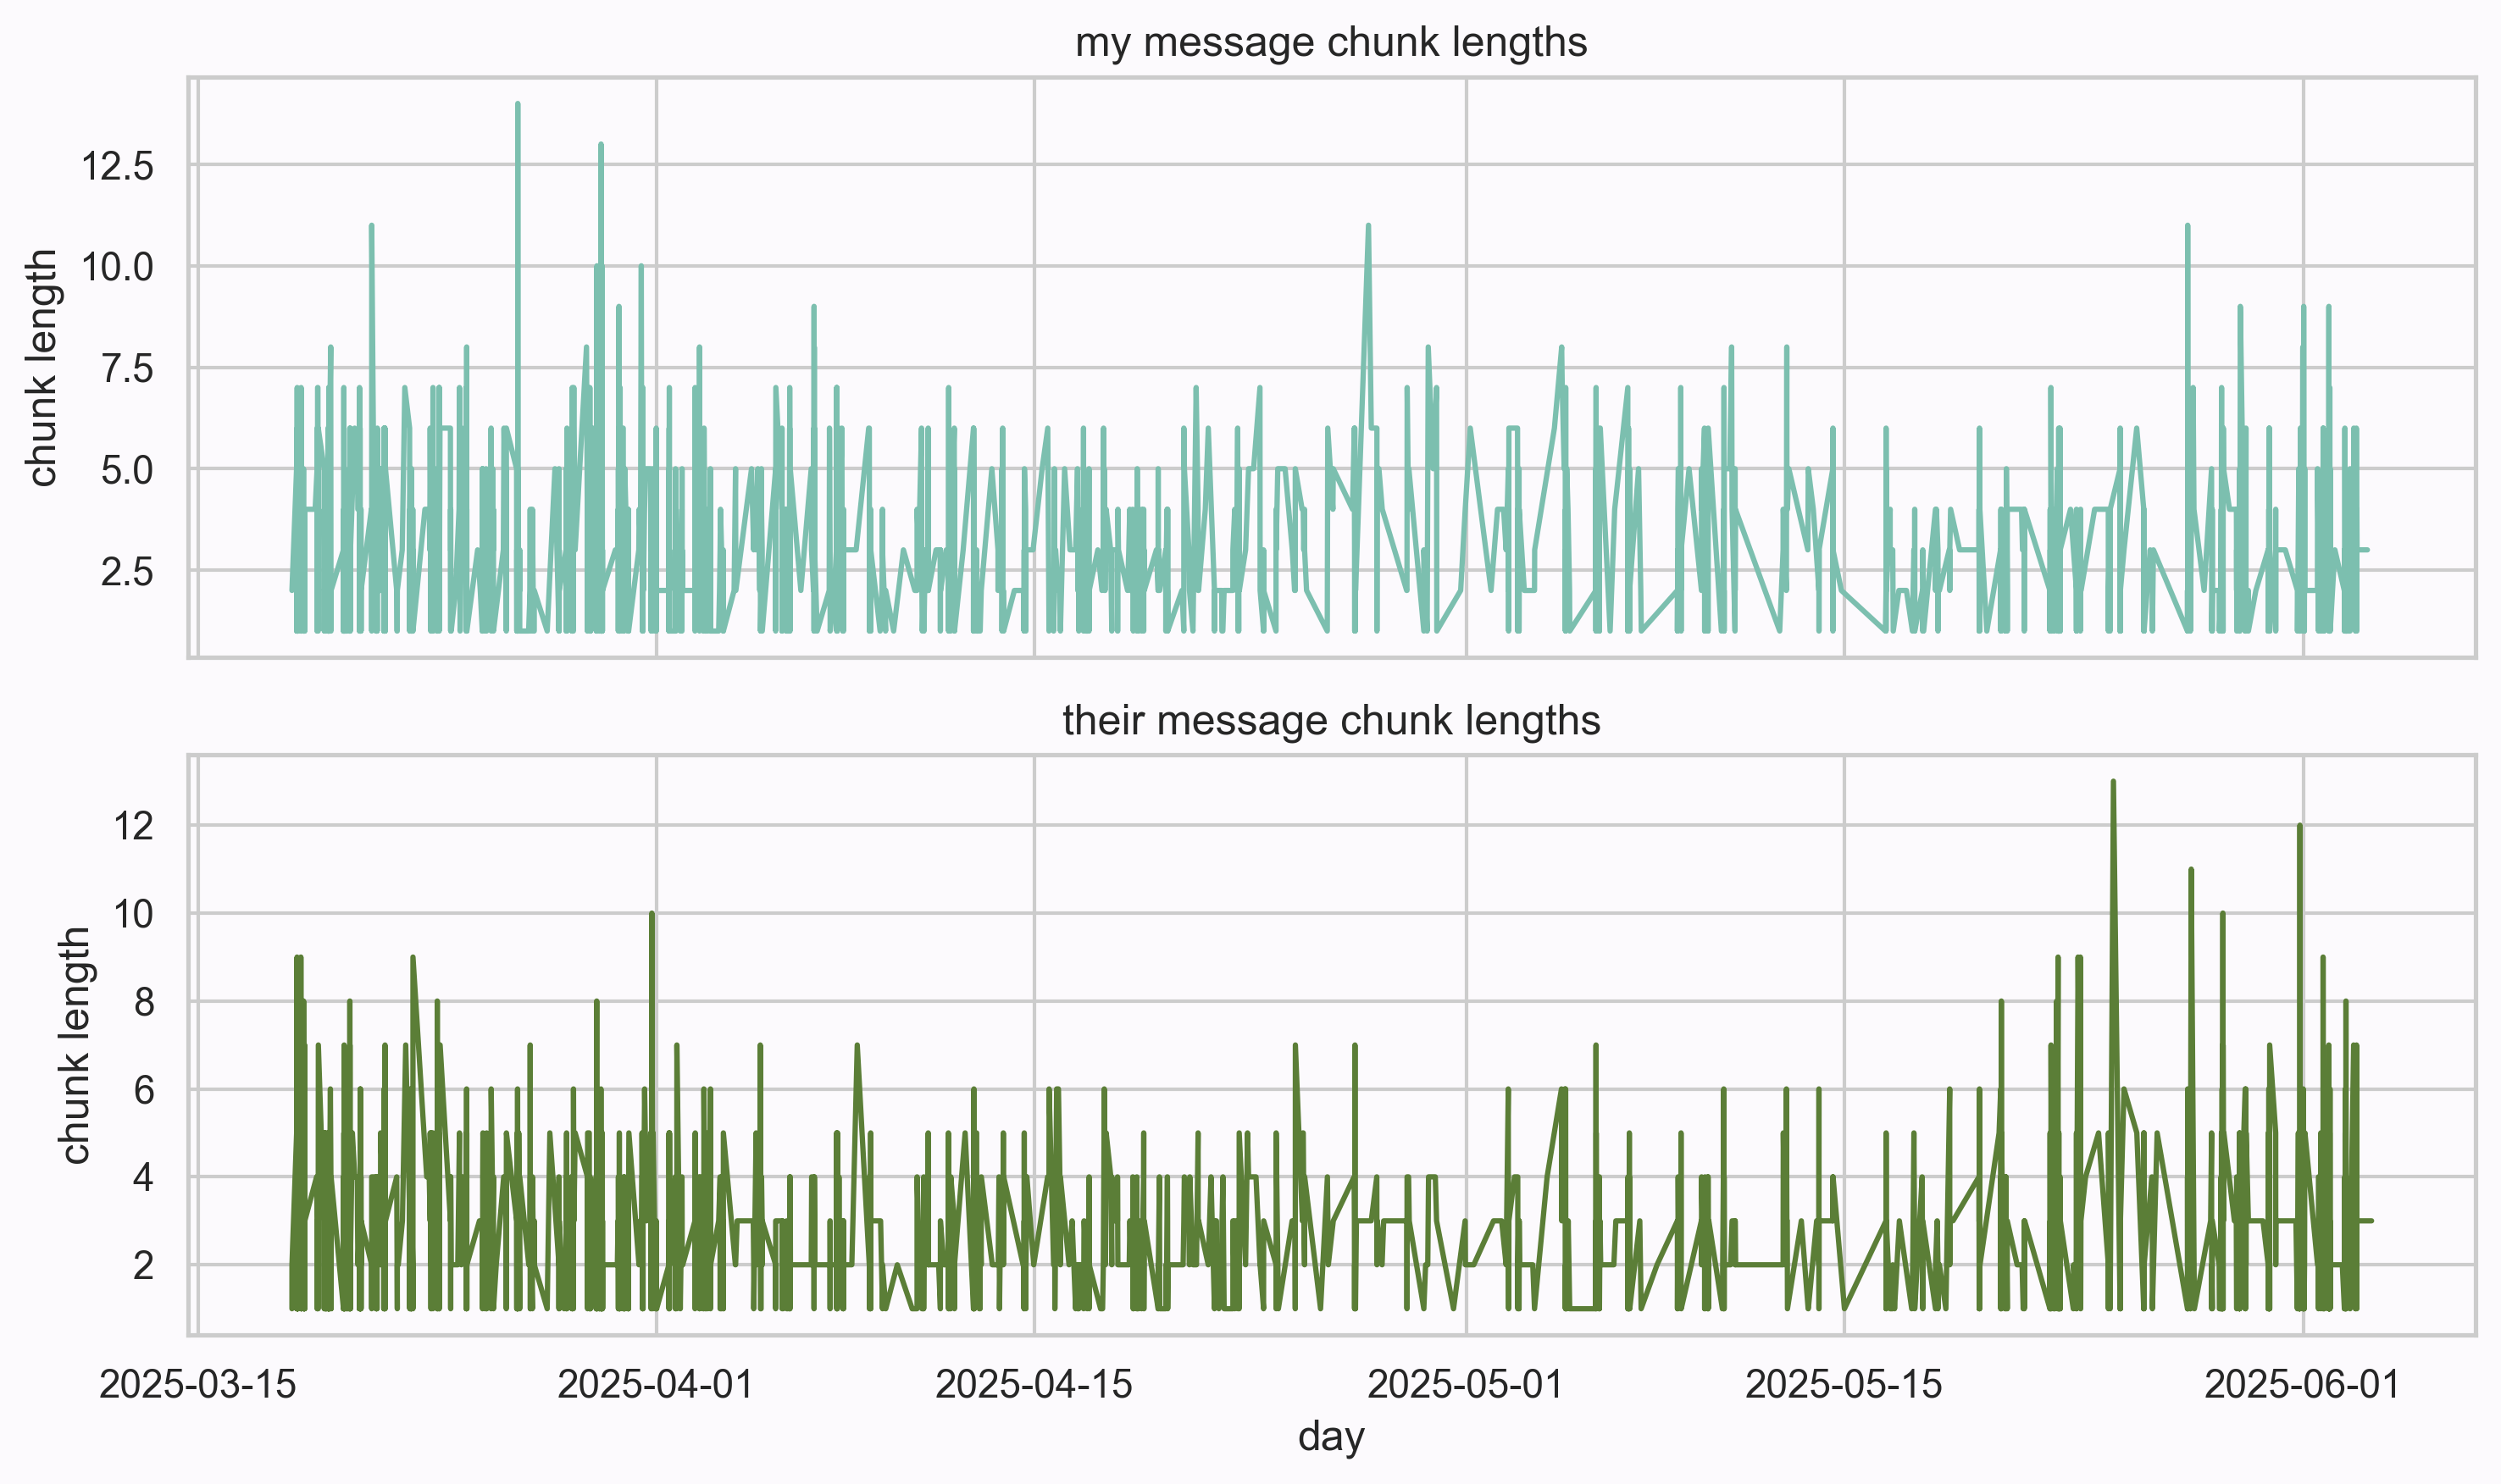

In [222]:
me = pd.read_csv("me_convo.csv")
not_me = pd.read_csv("not_me_convo.csv")
me["start_time"] = pd.to_datetime(me["start_time"], format="mixed").dt.tz_localize(None)
not_me["start_time"] = pd.to_datetime(not_me["start_time"], format="mixed").dt.tz_localize(None)
fig, axs = plt.subplots(2, 1, figsize=(10, 6), dpi=300, sharex=True)
axs[0].plot(me["start_time"], me["length"], color='#7CBFAF')
axs[0].set_ylabel("chunk length")
axs[0].set_title("my message chunk lengths")
axs[1].plot(not_me["start_time"], not_me["length"], color='#5B7E37')
axs[1].set_ylabel("chunk length")
axs[1].set_title("their message chunk lengths")
plt.xlabel("day")
plt.tight_layout()
plt.show()

distance btwn distributions 
1. total variational distance
2. earth mover's distance 
3. kullback-leibler divergence

use empirical distributions, we don't know what the actual probability distribution for length of messages per day is
wasserstein --> 

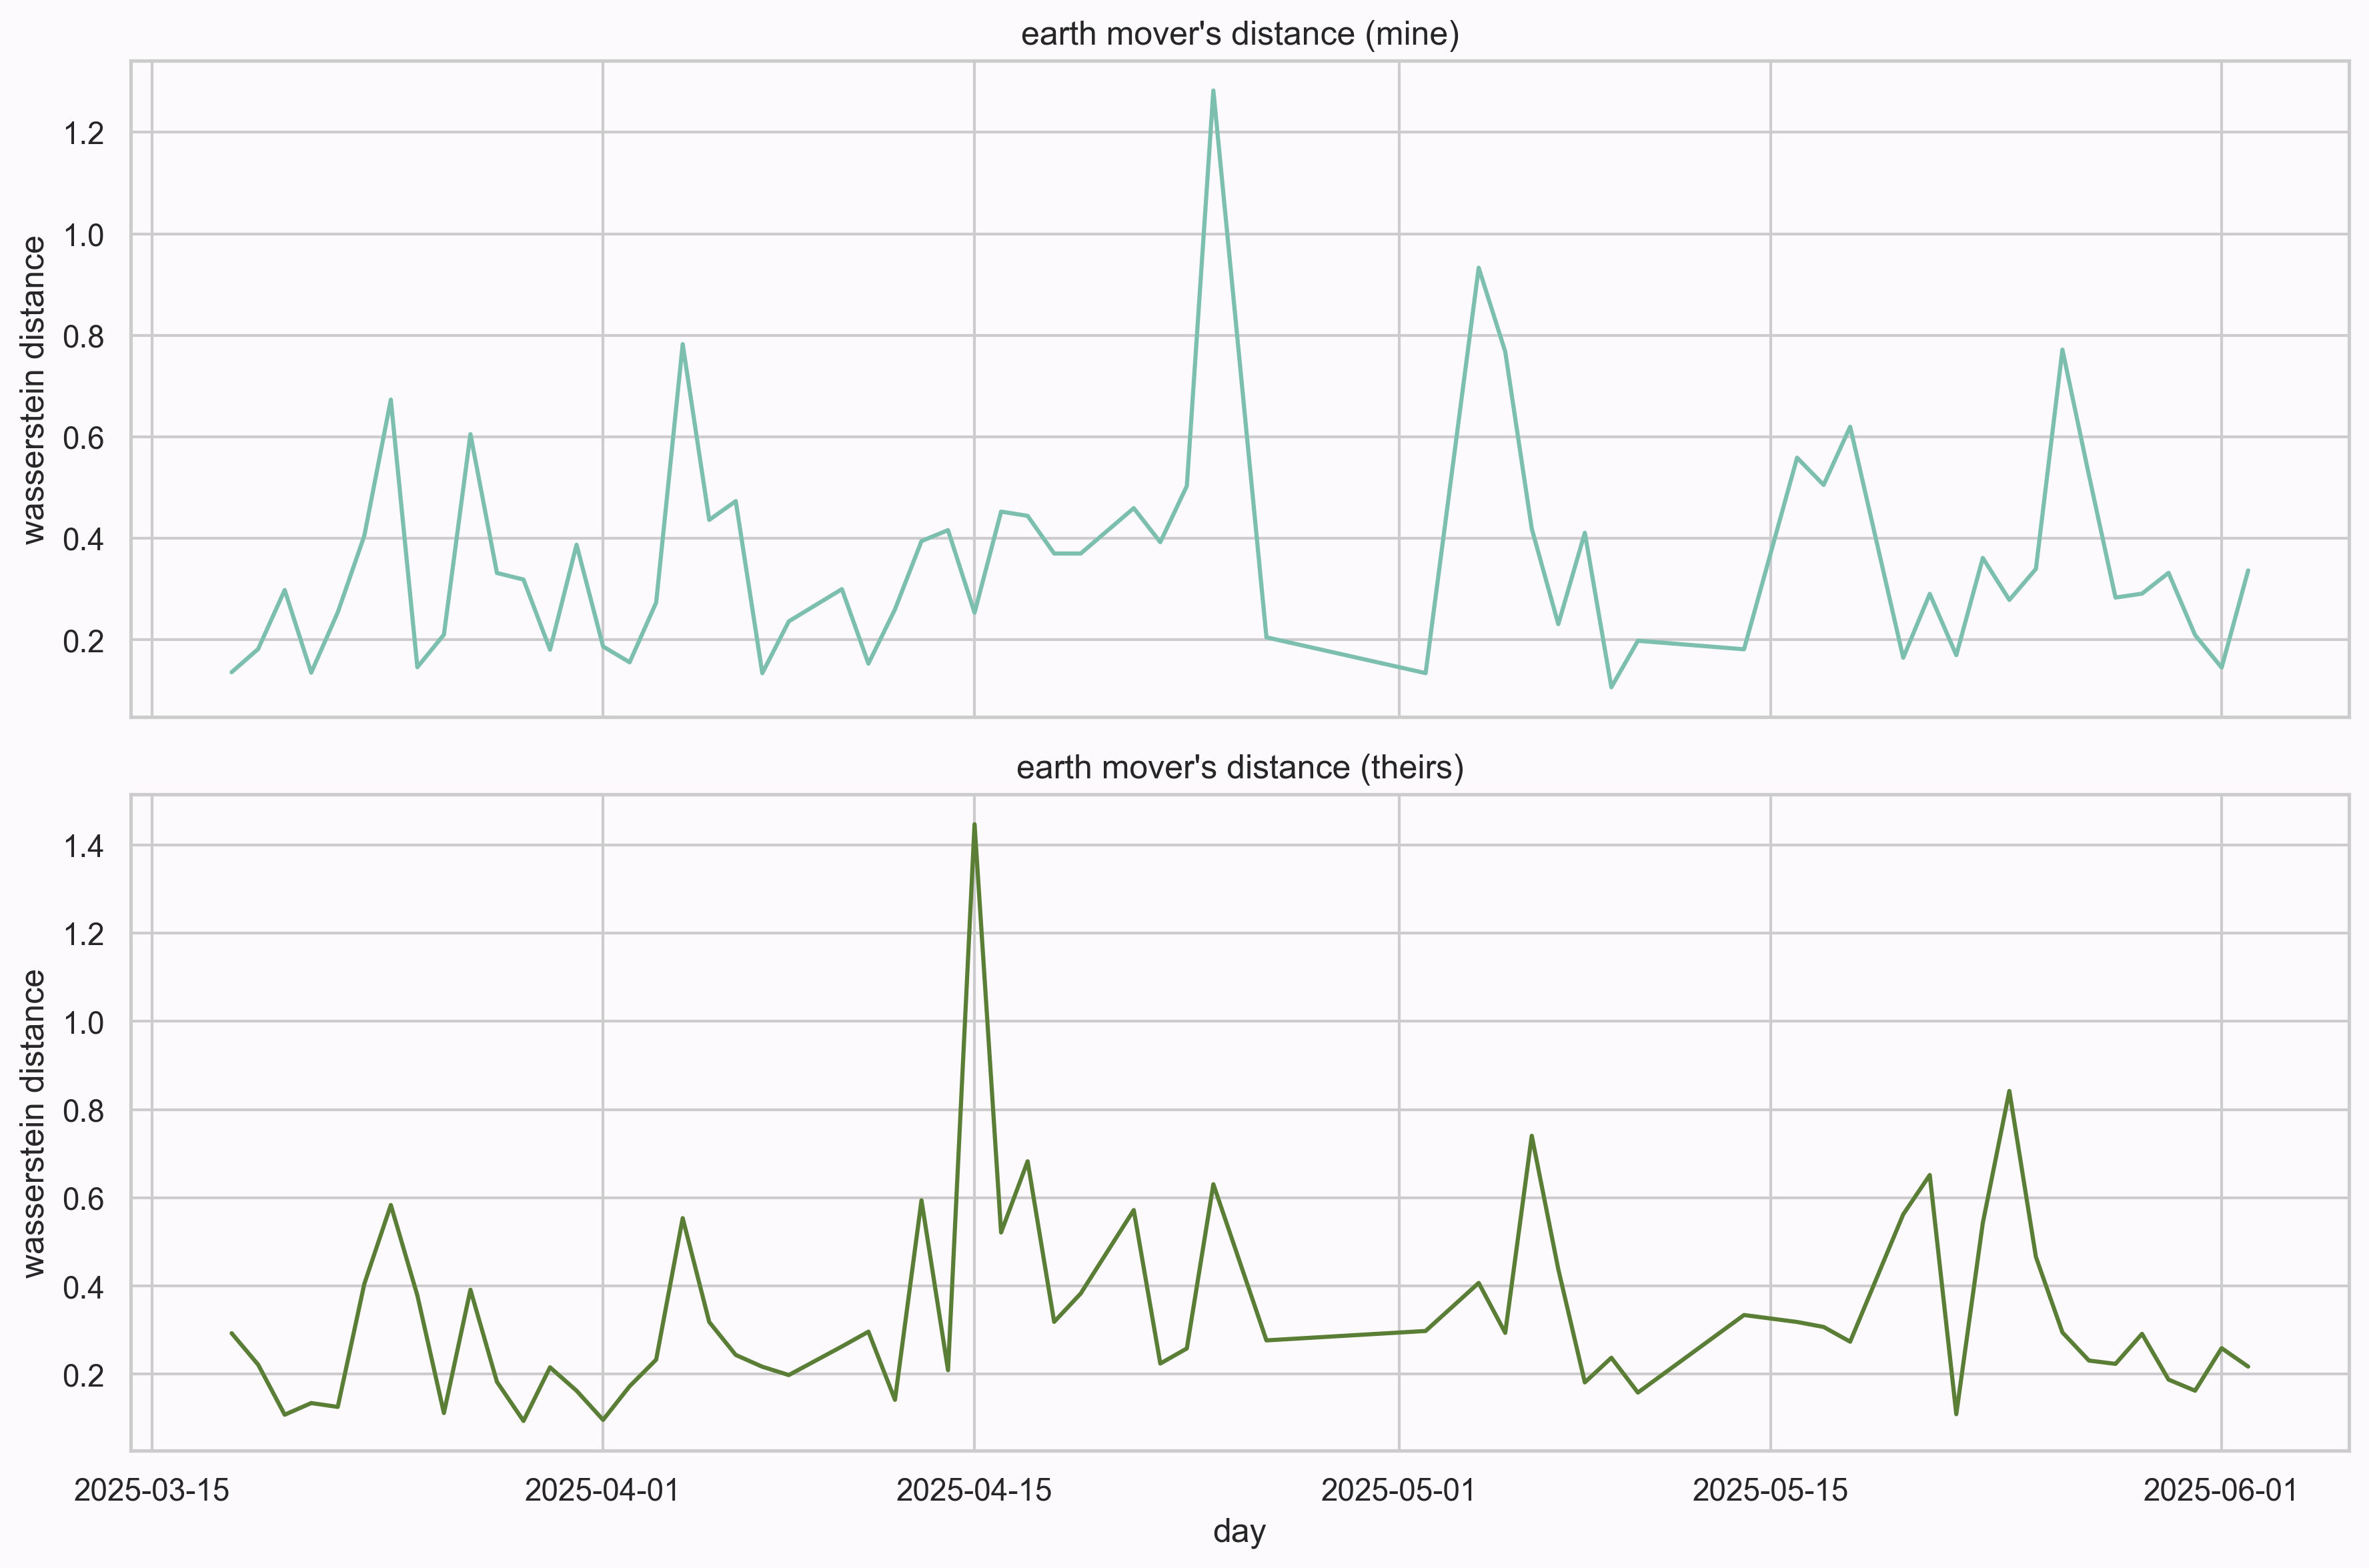

Top 3 days with highest Wasserstein distance (mine):
2025-04-24 — 1.2825
2025-05-04 — 0.9331
2025-04-04 — 0.7825
Top 3 days with highest Wasserstein distance (theirs):
2025-04-15 — 1.4468
2025-05-24 — 0.8420
2025-05-06 — 0.7404


In [223]:
def compute_daily_wasserstein(df):
    df["day"] = df["start_time"].dt.date
    df = df.sort_values("start_time").reset_index(drop=True)
    global_dist = df["length"].dropna().values
    results = []
    for day, group in df.groupby("day"):
        day_vals = group["length"].dropna().values
        if len(day_vals) < 10:
            continue
        wdist = wasserstein_distance(day_vals, global_dist)
        results.append({"day": day, "wdist": wdist})
    result_df = pd.DataFrame(results)
    result_df["day"] = pd.to_datetime(result_df["day"])
    return result_df

def plot_stacked_wasserstein(me_df, not_me_df):
    me_res = compute_daily_wasserstein(me_df)
    not_me_res = compute_daily_wasserstein(not_me_df)
    fig, axs = plt.subplots(2, 1, figsize=(12, 8), dpi=300, sharex=True)
    axs[0].plot(me_res["day"], me_res["wdist"], color='#7CBFAF', label="mine")
    axs[0].set_title("earth mover's distance (mine)")
    axs[0].set_ylabel("wasserstein distance")
    axs[1].plot(not_me_res["day"], not_me_res["wdist"], color='#5B7E37', label="theirs")
    axs[1].set_title("earth mover's distance (theirs)")
    axs[1].set_ylabel("wasserstein distance")
    axs[1].set_xlabel("day")
    for ax in axs:
        ax.tick_params(axis='x')
    plt.tight_layout()
    plt.show()

def print_top_wasserstein_days(wdist_df, label):
    top3 = wdist_df.sort_values("wdist", ascending=False).head(3)
    print(f"Top 3 days with highest Wasserstein distance ({label}):")
    for _, row in top3.iterrows():
        print(f"{row['day'].date()} — {row['wdist']:.4f}")


me_res = compute_daily_wasserstein(me)
not_me_res = compute_daily_wasserstein(not_me)
plot_stacked_wasserstein(me, not_me)
print_top_wasserstein_days(me_res, "mine")
print_top_wasserstein_days(not_me_res, "theirs")


4

In [224]:
mez = pd.read_csv("me_reply_turns.csv")
not_mez = pd.read_csv("not_me_reply_turns.csv")
mez["start_time"] = pd.to_datetime(mez["time"], format="mixed").dt.tz_localize(None)
not_mez["start_time"] = pd.to_datetime(not_me["start_time"], format="mixed").dt.tz_localize(None)

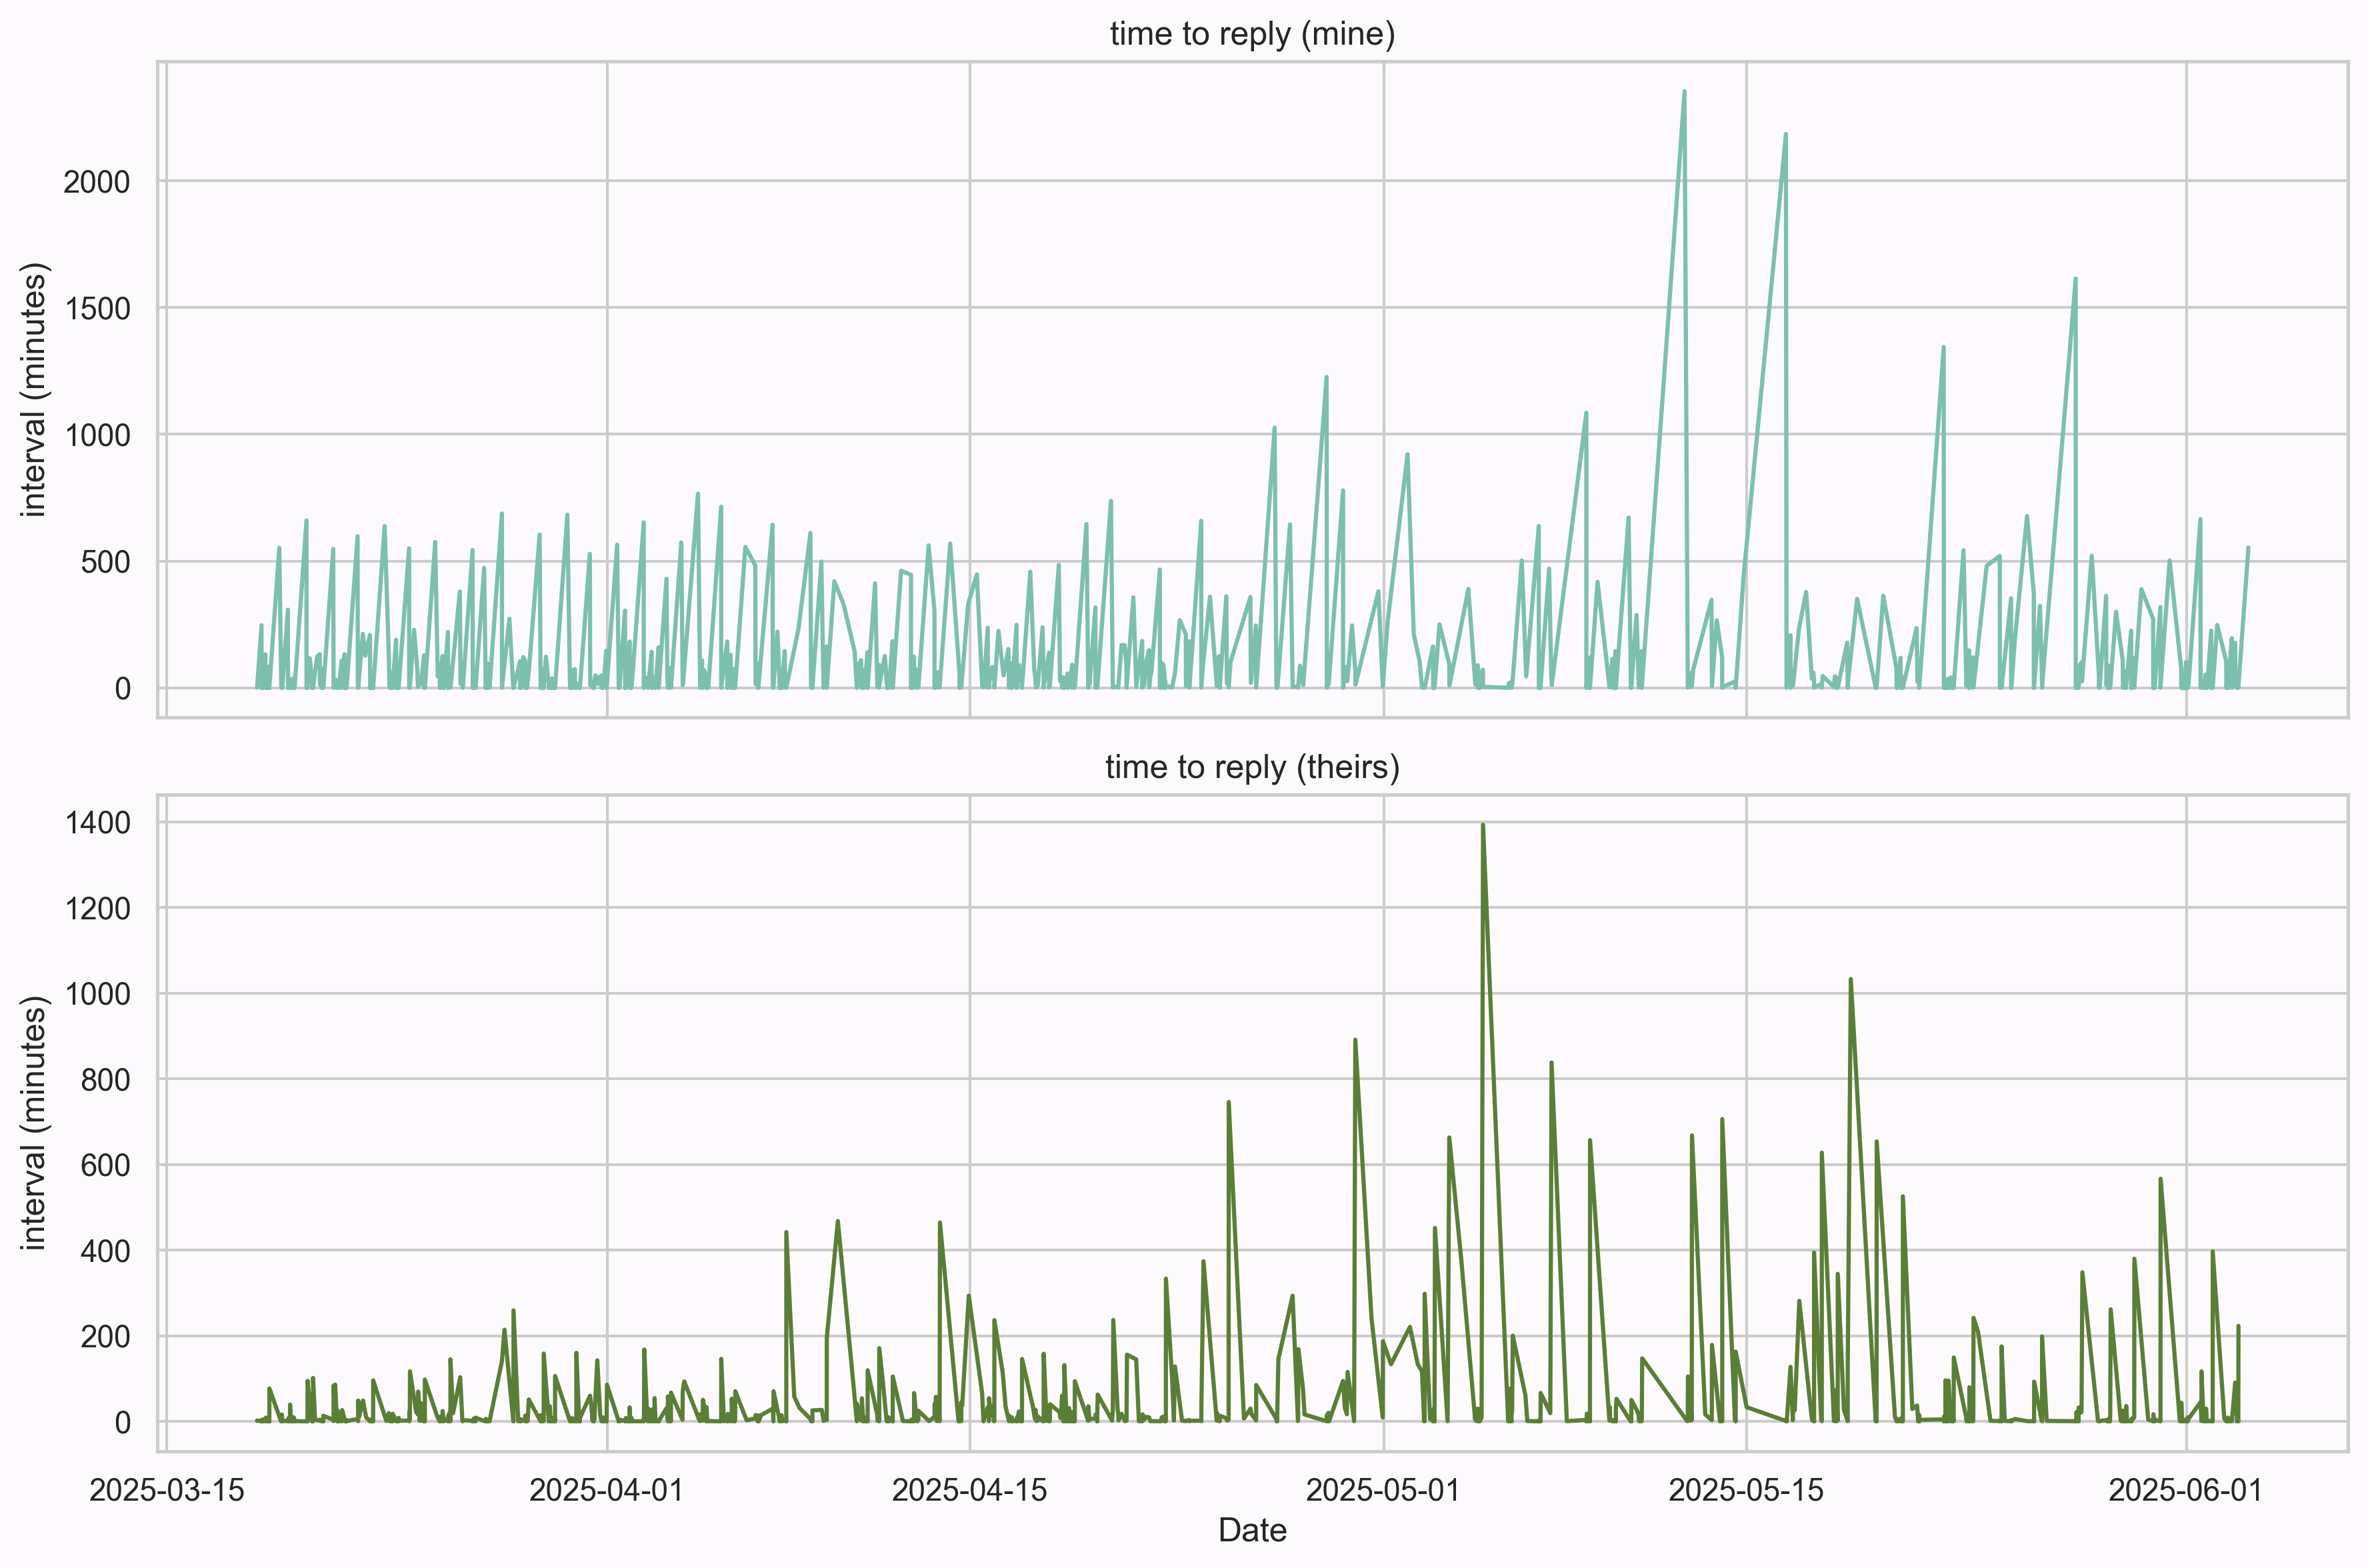

In [225]:
def plot_stacked_timeseries(me_df, not_me_df):
    me_df = me_df.sort_values('start_time')
    not_me_df = not_me_df.sort_values('start_time')
    fig, axs = plt.subplots(2, 1, figsize=(12, 8), dpi=300, sharex=True)
    axs[0].plot(me_df['start_time'], me_df['interval'], color='#7CBFAF', label='mine')
    axs[0].set_ylabel('interval (minutes)')
    axs[0].set_title('time to reply (mine)')
    axs[1].plot(not_me_df['start_time'], not_me_df['interval'], color='#5B7E37', label='theirs')
    axs[1].set_ylabel('interval (minutes)')
    axs[1].set_xlabel('Date')
    axs[1].set_title('time to reply (theirs)')
    for ax in axs:
        ax.tick_params(axis='x')
    plt.tight_layout()
    plt.show()

plot_stacked_timeseries(mez, not_mez)

In [226]:
def bootstrap_test(df, stat='mean', n_boot=10000):
    df['start_time'] = pd.to_datetime(df['start_time'])
    df['date'] = df['start_time'].dt.date
    results = []
    start = date(2025, 3, 28)
    end = date(2025, 5, 28)
    all_dates = [start + timedelta(days=i) for i in range((end - start).days + 1)]
    for d in all_dates:
        group = df[df['date'] == d]['interval']
        rest = df[df['date'] != d]['interval']
        if len(group) < 5:
            continue
        if stat == 'mean':
            boot_stats = np.array([rest.sample(len(group), replace=True).mean() for _ in range(n_boot)])
            observed = group.mean()
        elif stat == 'median':
            boot_stats = np.array([rest.sample(len(group), replace=True).median() for _ in range(n_boot)])
            observed = group.median()
        else:
            raise ValueError("stat must be 'mean' or 'median'")
        p_val = np.mean(np.abs(boot_stats - boot_stats.mean()) >= np.abs(observed - boot_stats.mean()))
        ci_lower = np.percentile(boot_stats, 2.5)
        ci_upper = np.percentile(boot_stats, 97.5)
        direction = 'higher' if observed > boot_stats.mean() else 'lower'
        results.append({
            'date': d,
            'p_value': p_val,
            'n_obs': len(group),
            'observed': observed,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper, 
            'direction': direction
        })
    return pd.DataFrame(results)

In [227]:
me4_mean = bootstrap_test(mez)
se4_mean = bootstrap_test(not_mez)

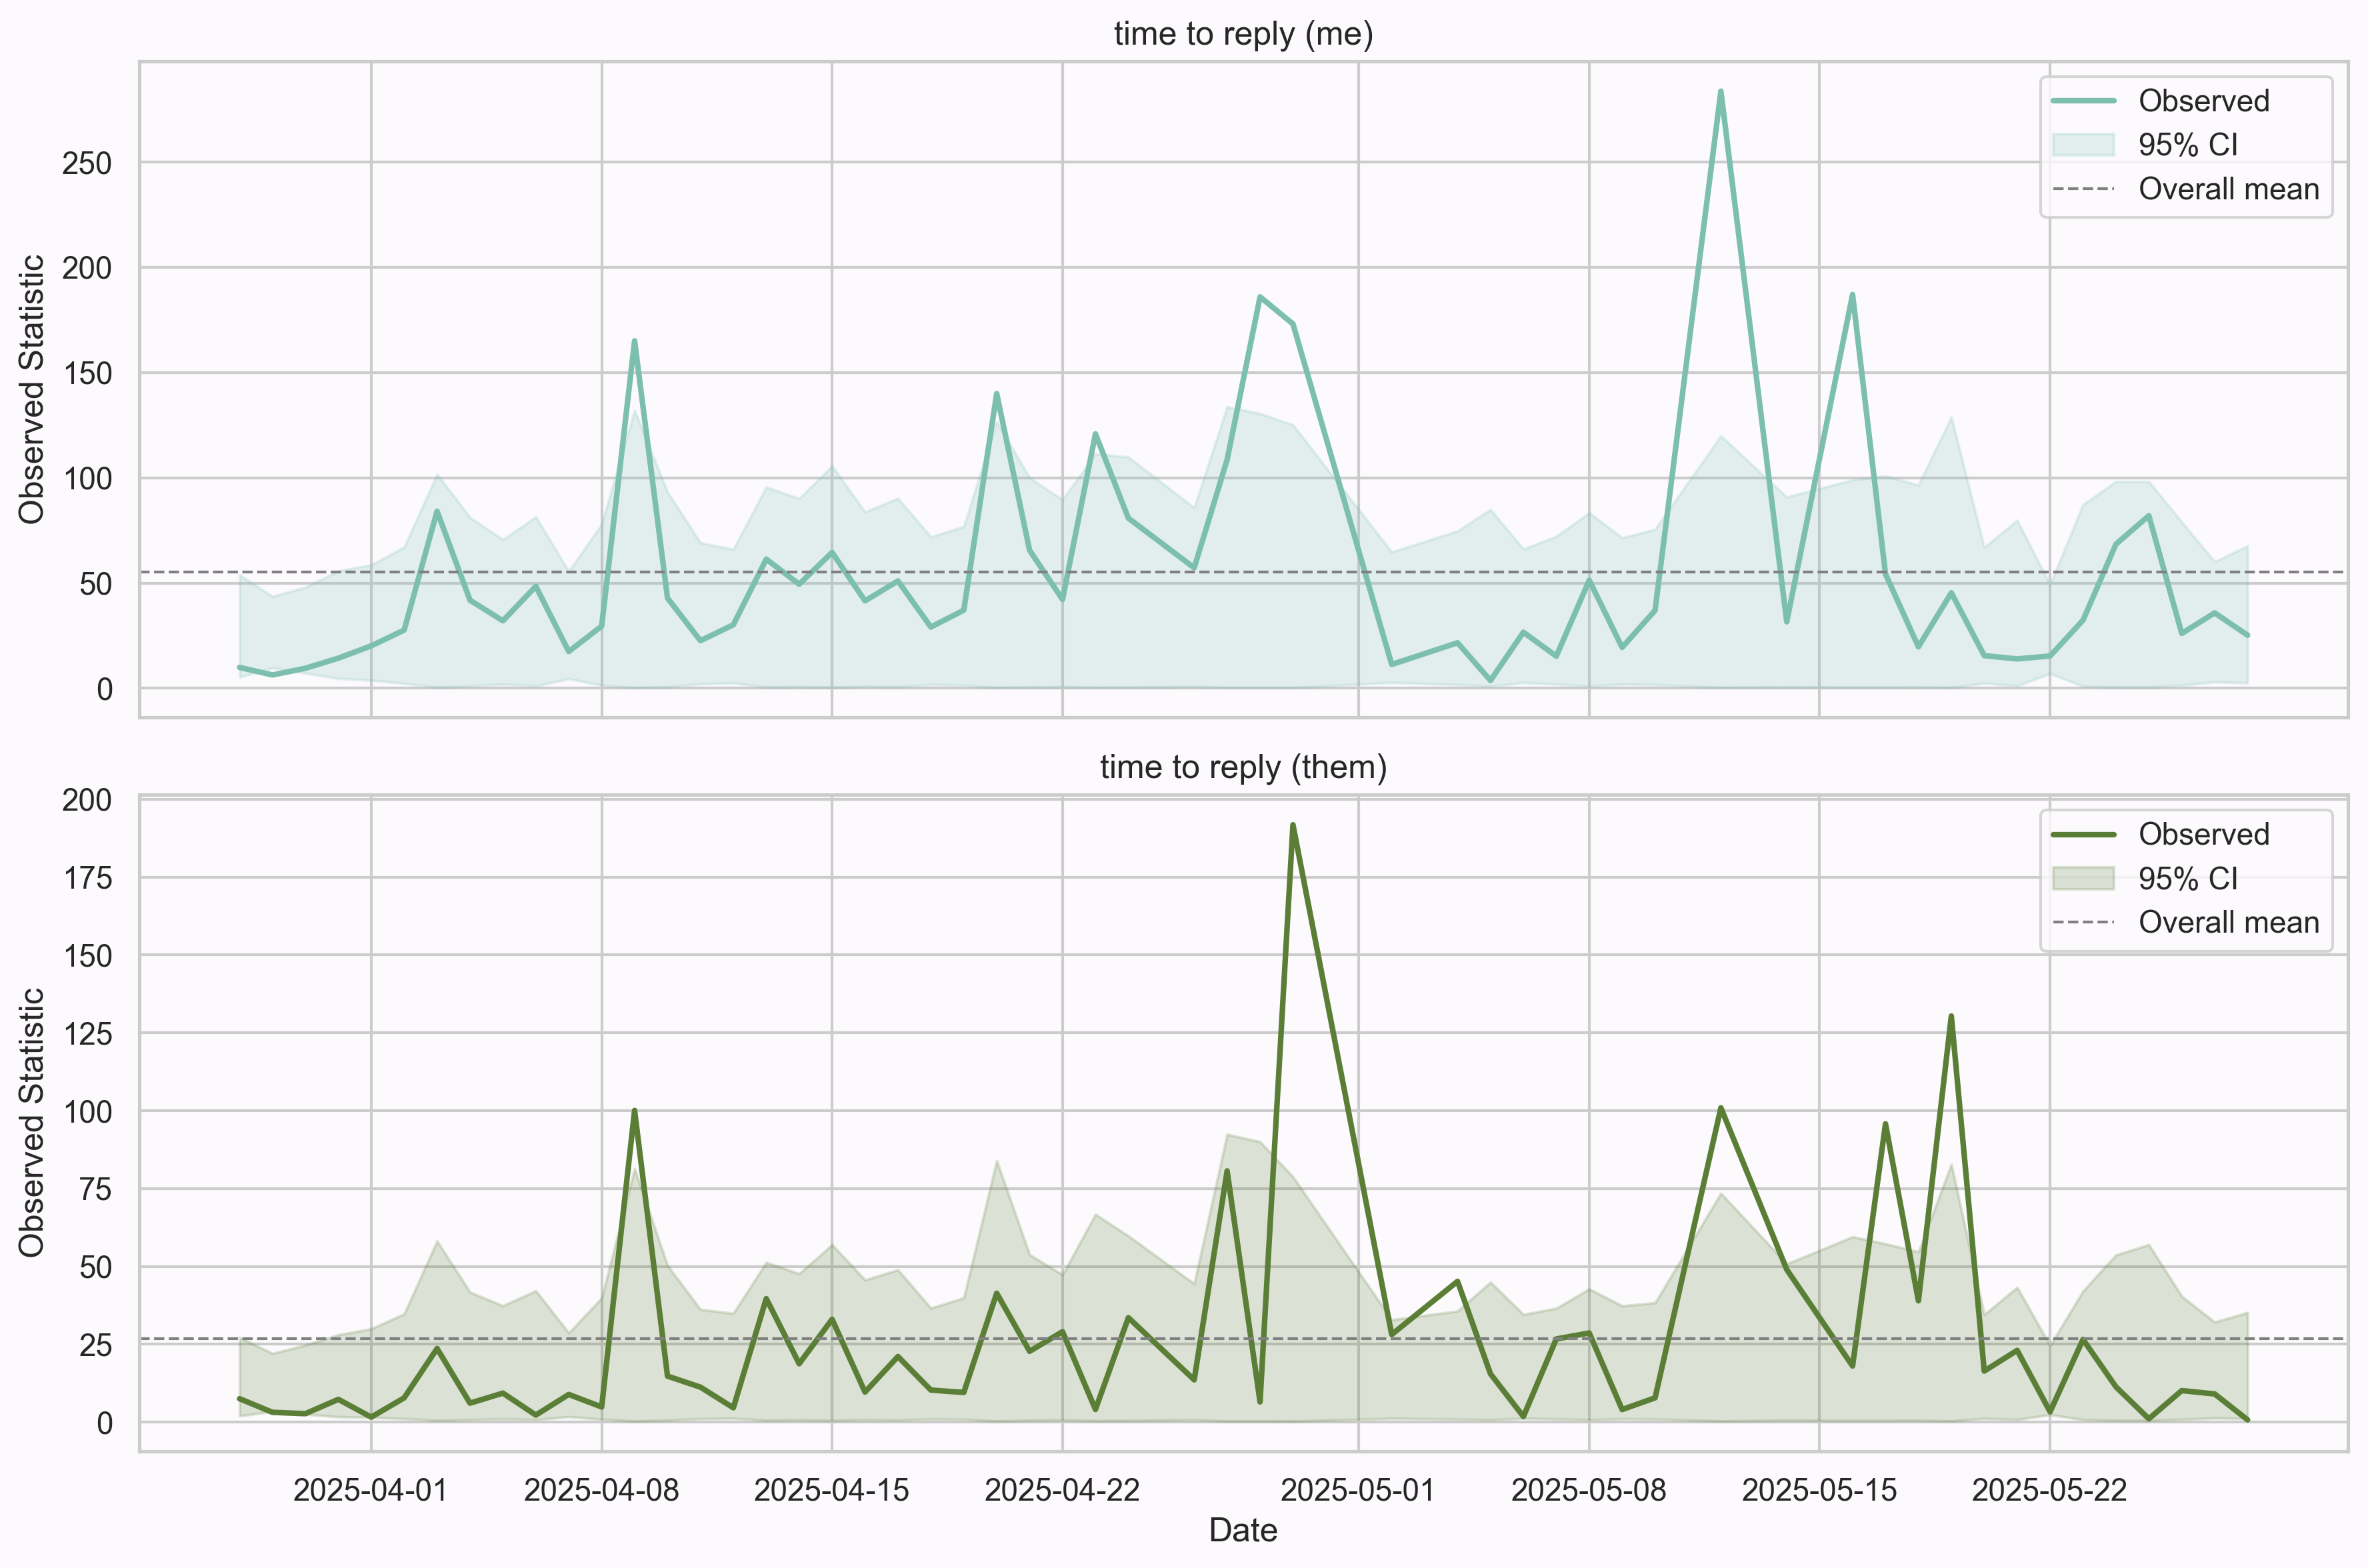

In [228]:
def plot_stacked_bootstrap(me_df, not_me_df, title1="time to reply (me)", title2="time to reply (them)"):
    fig, axs = plt.subplots(2, 1, figsize=(12, 8),dpi=300, sharex=True)
    for ax, results_df, color, title in zip(
        axs,
        [me_df, not_me_df],
        ['#7CBFAF', '#5B7E37'],
        [title1, title2]
    ):
        results_df = results_df.sort_values("date")
        x = pd.to_datetime(results_df["date"])
        y = results_df["observed"]
        lower = results_df["ci_lower"]
        upper = results_df["ci_upper"]
        ax.plot(x, y, label="Observed", color=color, linewidth=2)
        ax.fill_between(x, lower, upper, color=color, alpha=0.2, label="95% CI")
        ax.axhline(np.mean(y), color='gray', linestyle='--', linewidth=1, label="Overall mean")
        ax.set_title(title)
        ax.set_ylabel("Observed Statistic")
        ax.tick_params(axis='x')
    axs[1].set_xlabel("Date")
    axs[0].legend()
    axs[1].legend()
    plt.tight_layout()
    plt.show()

plot_stacked_bootstrap(me4_mean, se4_mean)

In [229]:
mytop3 = me4_mean.sort_values("p_value").head(3)
print(mytop3)

theirtop3 = se4_mean.sort_values("p_value").head(3)
print(theirtop3)


          date  p_value  n_obs  observed  ci_lower  ci_upper direction
40  2025-05-12  0.00080      9 283.69165   0.31490 119.91741    higher
42  2025-05-16  0.00270     13 187.09755   0.41914  99.02556    higher
30  2025-04-28  0.01100      7 185.96418   0.23877 130.52063    higher
          date  p_value  n_obs  observed  ci_lower  ci_upper direction
31  2025-04-29  0.00210      6 191.80943   0.26819  78.76889    higher
45  2025-05-19  0.00390      8 130.39861   0.33948  82.76560    higher
43  2025-05-17  0.00460     14  95.79118   0.51304  57.27168    higher
